# Multi-agent network
Adapted from the original [Langgraph multi-agent notebook example](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/multi-agent-collaboration.ipynb)

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.



## Setup
we build multi agent setup with 3 nodes -  Researcher, Chart Generator, and Chart Summarizer. Note the chart summarizer node requires a multimodal LLM, in order to take the chart image as an input properly.
The resulting graph will look something like the following diagram: 

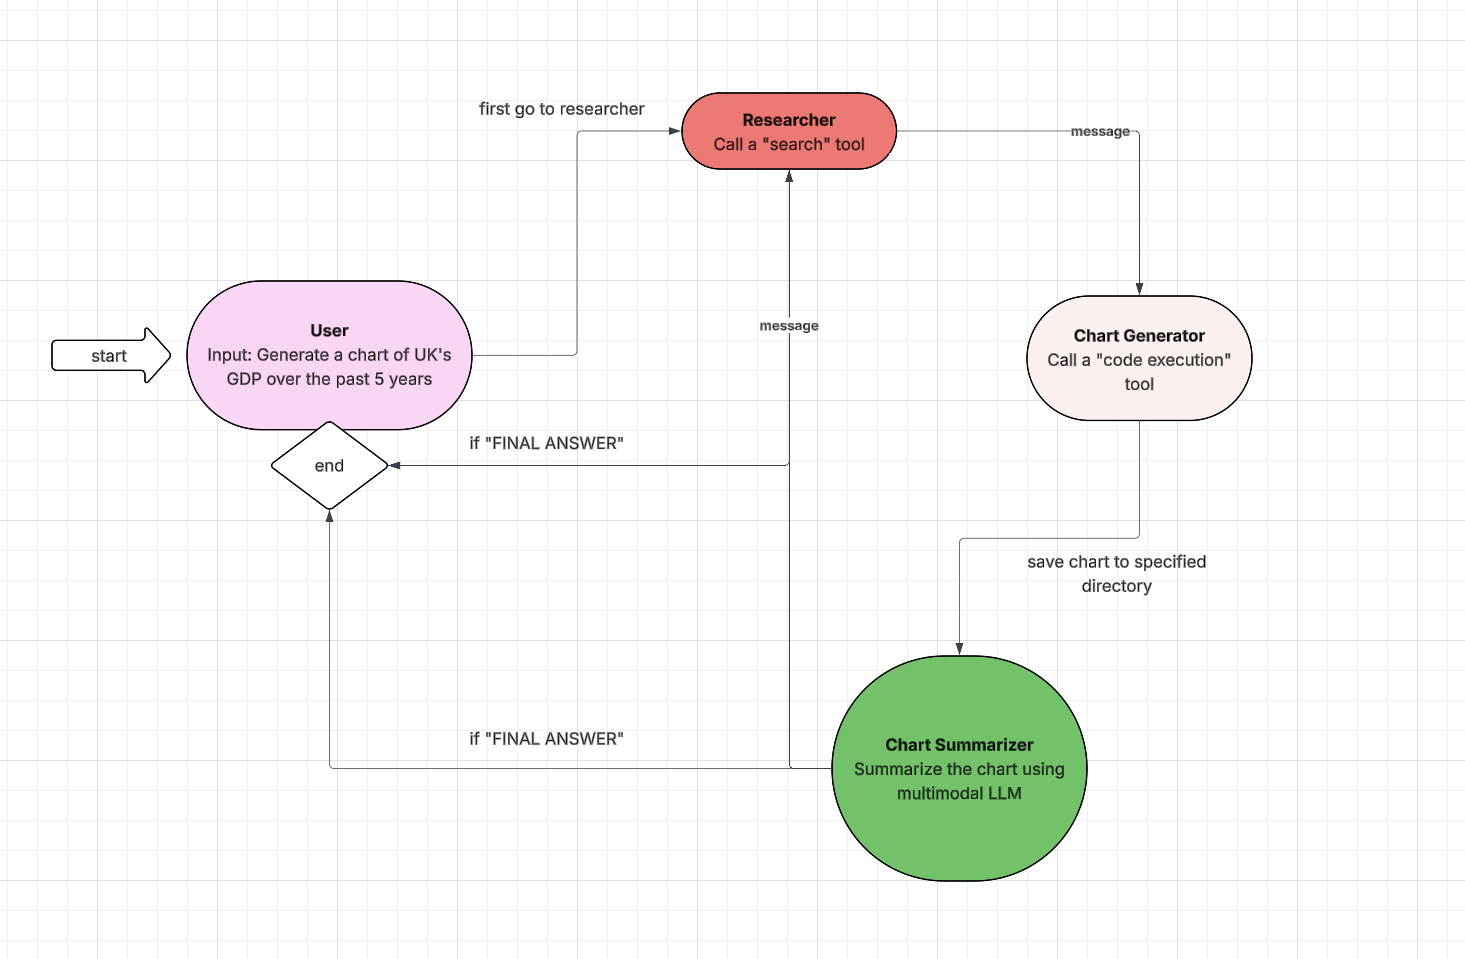


In [ ]:
%%capture --no-stderr
# pip install -U langchain_community langchain_openai langchain_experimental matplotlib langgraph

####  We use Tavily to perform web search with LLMs for illustration. But any search tool should do.

In [ ]:
import os

# need both API keys
os.environ["TAVILY_API_KEY"] = (
    "..."  # get a free one at https://app.tavily.com/home
)
os.environ["OPENAI_API_KEY"] = "sk-..."

os.environ["TRULENS_OTEL_TRACING"] = (
    "1"  # to enable OTEL tracing -> note the Snowsight UI experience for now is limited to PuPr customers, not yet supported for OSS.
)

## Define tools

We will also define some tools that our agents will use in the future

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [ ]:
import json
from typing import Annotated, Literal

from IPython.display import Image
from IPython.display import display
from langchain.load.dump import dumps
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from trulens.core.otel.instrument import instrument
from trulens.otel.semconv.trace import BASE_SCOPE
from trulens.otel.semconv.trace import SpanAttributes

from langgraph.graph import END
from langgraph.graph import START
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command


def build_graph(search_max_results: int = 5):
    def make_system_prompt(suffix: str) -> str:
        return (
            "You are a helpful AI assistant, collaborating with other assistants."
            " Use the provided tools to progress towards answering the question."
            " If you are unable to fully answer, that's OK, another assistant with different tools "
            " will help where you left off. Execute what you can to make progress."
            " If you or any of the other assistants have the final answer or deliverable,"
            " prefix your response with FINAL ANSWER so the team knows to stop."
            f"\n{suffix}"
        )

    tavily_tool = TavilySearchResults(max_results=search_max_results)

    # Warning: This executes code locally, which can be unsafe when not sandboxed

    repl = PythonREPL()

    @tool
    @instrument(
        span_type="PYTHON_REPL_TOOL",
        attributes={
            f"{BASE_SCOPE}.python_tool_input_code": "code",
        },
    )
    def python_repl_tool(
        code: Annotated[
            str, "The python code to execute to generate your chart."
        ],
    ):
        """Use this to execute python code. If you want to see the output of a value,
        you should print it out with `print(...)`. This is visible to the user."""

        try:
            result = repl.run(code)
        except BaseException as e:
            return f"Failed to execute. Error: {repr(e)}"
        result_str = (
            f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
        )
        return (
            result_str
            + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
        )

    llm = ChatOpenAI(
        model="gpt-4o",
    )

    def get_next_node(last_message: BaseMessage, goto: str):
        if "FINAL ANSWER" in last_message.content:
            # Any agent decided the work is done
            return END
        return goto

    # Research agent and node
    research_agent = create_react_agent(
        llm,
        tools=[tavily_tool],
        prompt=make_system_prompt(
            "You can only do research. You are working with both a chart generator and a chart summarizer colleagues."
        ),
    )

    @instrument(
        span_type="RESEARCH_NODE",
        attributes=lambda ret, exception, *args, **kwargs: {
            f"{BASE_SCOPE}.research_node_input": args[0]["messages"][
                -1
            ].content,
            f"{BASE_SCOPE}.research_node_response": ret.update["messages"][
                -1
            ].content
            if hasattr(ret, "update")
            else json.dumps(ret, indent=4, sort_keys=True),
            f"{BASE_SCOPE}.tool_messages": [
                dumps(message)
                for message in ret.update["messages"]
                if isinstance(message, ToolMessage)
            ]
            if hasattr(ret, "update")
            else "No tool call",
        },
    )
    @instrument(
        span_type=SpanAttributes.SpanType.RETRIEVAL,
        attributes=lambda ret, exception, *args, **kwargs: {
            SpanAttributes.RETRIEVAL.QUERY_TEXT: args[0]["messages"][
                -1
            ].content,
            SpanAttributes.RETRIEVAL.RETRIEVED_CONTEXTS: [
                ret.update["messages"][-1].content
            ]
            if hasattr(ret, "update")
            else [json.dumps(ret, indent=4, sort_keys=True)],
        },
    )
    def research_node(
        state: MessagesState,
    ) -> Command[Literal["chart_generator"]]:
        result = research_agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "chart_generator")
        # wrap in a human message, as not all providers allow
        # AI message at the last position of the input messages list
        result["messages"][-1] = HumanMessage(
            content=result["messages"][-1].content, name="researcher"
        )
        return Command(
            update={
                # share internal message history of research agent with other agents
                "messages": result["messages"],
            },
            goto=goto,
        )

    # Chart generator agent and node
    # NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
    chart_agent = create_react_agent(
        llm,
        [python_repl_tool],
        prompt=make_system_prompt(
            "You can only generate charts. The generated chart should be save at a local directory at current directory PATH './langgraph_saved_images' , and this PATH should be sent to your colleague. You are working with a chart summarizer colleague."
        ),
    )

    @instrument(
        span_type="CHART_GENERATOR_NODE",
        attributes=lambda ret, exception, *args, **kwargs: {
            f"{BASE_SCOPE}.chart_node_input": args[0]["messages"][-1].content,
            f"{BASE_SCOPE}.chart_node_response": ret.update["messages"][
                -1
            ].content
            if hasattr(ret, "update")
            else json.dumps(ret, indent=4, sort_keys=True),
        },
    )
    def chart_node(
        state: MessagesState,
    ) -> Command[Literal["chart_summarizer"]]:
        result = chart_agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "chart_summarizer")
        # wrap in a human message, as not all providers allow
        # AI message at the last position of the input messages list
        result["messages"][-1] = HumanMessage(
            content=result["messages"][-1].content, name="chart_generator"
        )
        return Command(
            update={
                # share internal message history of chart agent with other agents
                "messages": result["messages"],
            },
            goto=goto,
        )

    # Build the image captioning agent.
    # If you have any specific image processing tools (e.g., for extracting chart images),
    # you can add them in the tools list. For now, we leave it empty.
    chart_summary_agent = create_react_agent(
        llm,
        tools=[],  # Add image processing tools if available/needed.
        prompt=make_system_prompt(
            "You can only generate image captions. You are working with a researcher colleague and a chart generator colleague. "
            + "Your task is to generate a concise summary for the provided chart image saved at a local PATH, where the PATH should be and only be provided by your chart generator colleague. The summary should be no more than 3 sentences."
        ),
    )

    @instrument(
        span_type="CHART_SUMMARY_NODE",
        attributes=lambda ret, exception, *args, **kwargs: {
            f"{BASE_SCOPE}.summary_node_input": args[0]["messages"][-1].content,
            f"{BASE_SCOPE}.summary_node_output": ret.update["messages"][
                -1
            ].content
            if hasattr(ret, "update")
            else "NO SUMMARY GENERATED",
        },
    )
    def chart_summary_node(
        state: MessagesState,
    ) -> Command[Literal["researcher", END]]:
        result = chart_summary_agent.invoke(state)
        # After captioning the image, we send control back (e.g., to the researcher)
        goto = get_next_node(result["messages"][-1], "researcher")
        # Wrap the output message in a HumanMessage to maintain consistency in the conversation flow.
        result["messages"][-1] = HumanMessage(
            content=result["messages"][-1].content, name="chart_summarizer"
        )
        return Command(
            update={"messages": result["messages"]},
            goto=goto,
        )

    workflow = StateGraph(MessagesState)
    workflow.add_node("researcher", research_node)
    workflow.add_node("chart_generator", chart_node)
    workflow.add_node("chart_summarizer", chart_summary_node)

    workflow.add_edge(START, "researcher")
    graph = workflow.compile()

    return graph

In [ ]:
import datetime
import time

from snowflake.snowpark import Session
from trulens.apps.app import TruApp
from trulens.connectors.snowflake import SnowflakeConnector
from trulens.core.run import Run
from trulens.core.run import RunConfig

# Snowflake account for trulens


snowflake_connection_parameters = {
    "account": os.environ["SNOWFLAKE_ACCOUNT"],
    "user": os.environ["SNOWFLAKE_USER"],
    "password": os.environ["SNOWFLAKE_USER_PASSWORD"],
    "database": os.environ["SNOWFLAKE_DATABASE"],
    "schema": os.environ["SNOWFLAKE_SCHEMA"],
    "role": os.environ["SNOWFLAKE_ROLE"],
    "warehouse": os.environ["SNOWFLAKE_WAREHOUSE"],
}
snowpark_session_trulens = Session.builder.configs(
    snowflake_connection_parameters
).create()


trulens_sf_connector = SnowflakeConnector(
    snowpark_session=snowpark_session_trulens
)


class TruAgent:
    def __init__(self, max_results=3):
        self.graph = build_graph(search_max_results=max_results)

    @instrument(
        span_type=SpanAttributes.SpanType.RECORD_ROOT,
        attributes={
            SpanAttributes.RECORD_ROOT.INPUT: "query",
            SpanAttributes.RECORD_ROOT.OUTPUT: "return",
        },
    )
    def invoke_agent_graph(self, query: str) -> str:
        events = self.graph.stream(
            {
                "messages": [("user", query)],
            },
            # Maximum number of steps to take in the graph
            {"recursion_limit": 150},
        )

        # resp_messages = []

        for event in events:
            messages = list(event.values())[0]["messages"]
        return (
            messages[-1].content
            if messages and hasattr(messages[-1], "content")
            else ""
        )


tru_agent_single_search = TruAgent(max_results=1)
tru_agent_better_search = TruAgent(max_results=3)


APP_NAME = "Langgraph multi-agent demo"

tru_agent_app_single_search = TruApp(
    tru_agent_single_search,
    app_name=APP_NAME,
    app_version="search limit 1",
    connector=trulens_sf_connector,
    main_method=tru_agent_single_search.invoke_agent_graph,
)
tru_agent_app_better_search = TruApp(
    tru_agent_better_search,
    app_name=APP_NAME,
    app_version="search limit 3",
    connector=trulens_sf_connector,
    main_method=tru_agent_better_search.invoke_agent_graph,
)


st_1 = datetime.datetime.fromtimestamp(time.time()).strftime(
    "%Y-%m-%d %H:%M:%S"
)

run_config_1 = RunConfig(
    run_name="Multi-agent demo run single search result",
    description="this is a run with a single search limit for the search tool",
    dataset_name="Research test dataset",
    source_type="DATAFRAME",
    label="langgraph demo",
    dataset_spec={
        "RECORD_ROOT.INPUT": "query",
    },
)
st_2 = datetime.datetime.fromtimestamp(time.time()).strftime(
    "%Y-%m-%d %H:%M:%S"
)

run_config_2 = RunConfig(
    run_name="Multi-agent demo run higher search results limit",
    description="this is a run with a higher search limit for the search tool",
    dataset_name="Research test dataset",
    source_type="DATAFRAME",
    label="langgraph demo",
    dataset_spec={
        "RECORD_ROOT.INPUT": "query",
    },
)

run_1: Run = tru_agent_app_single_search.add_run(run_config_1)
run_2: Run = tru_agent_app_better_search.add_run(run_config_2)

display(Image(tru_agent_better_search.graph.get_graph().draw_png()))

In [ ]:
import pandas as pd

user_queries = [
    "First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, summarize the chart, and finish.",
    "Compare the stock prices of Uber and Lyft and summarize the trends. then make a chart to show comparison. Once you make the chart, summarize the chart, finish.",
    "How have the stock prices of the magnificent 7 stocks done over the past month? make a line chart of it. Once you make the chart, summarize the chart, finish.",
    "How has the GDP of the G7 countries evolved over the last 20 years? Which country has seen the highest average growth rate? then make a informational chart of it. Once you make the chart, summarize the chart, finish.",
    "What are the top 5 countries with the highest inequality in income? Use metrics from the World Bank or other reputable source. Make a chart that best illustrates the top 5 countries. Once the cahrt is genrated, summarize the chart, finish.",
]

user_queries_df = pd.DataFrame(user_queries, columns=["query"])

run_1.start(input_df=user_queries_df)
run_2.start(input_df=user_queries_df)

In [ ]:
import time

while run_1.get_status() == "INVOCATION_IN_PROGRESS":
    time.sleep(3)
while run_2.get_status() == "INVOCATION_IN_PROGRESS":
    time.sleep(3)

In [ ]:
run_2.get_status()

### Compute metrics:
Here, we compute context relevance for the retrieval quality of the Tavily web search tool, and groundedness for the summaries generated from the charts to evaluate whether the text summaries are supported by the content in the graphical charts. 

In [ ]:
run_1.compute_metrics(["groundedness", "context_relevance"])
run_2.compute_metrics(["groundedness", "context_relevance"])

### One can now head to their Snowflake account -> AI & ML tab -> Evaluation tab, and find the registered apps and traces 

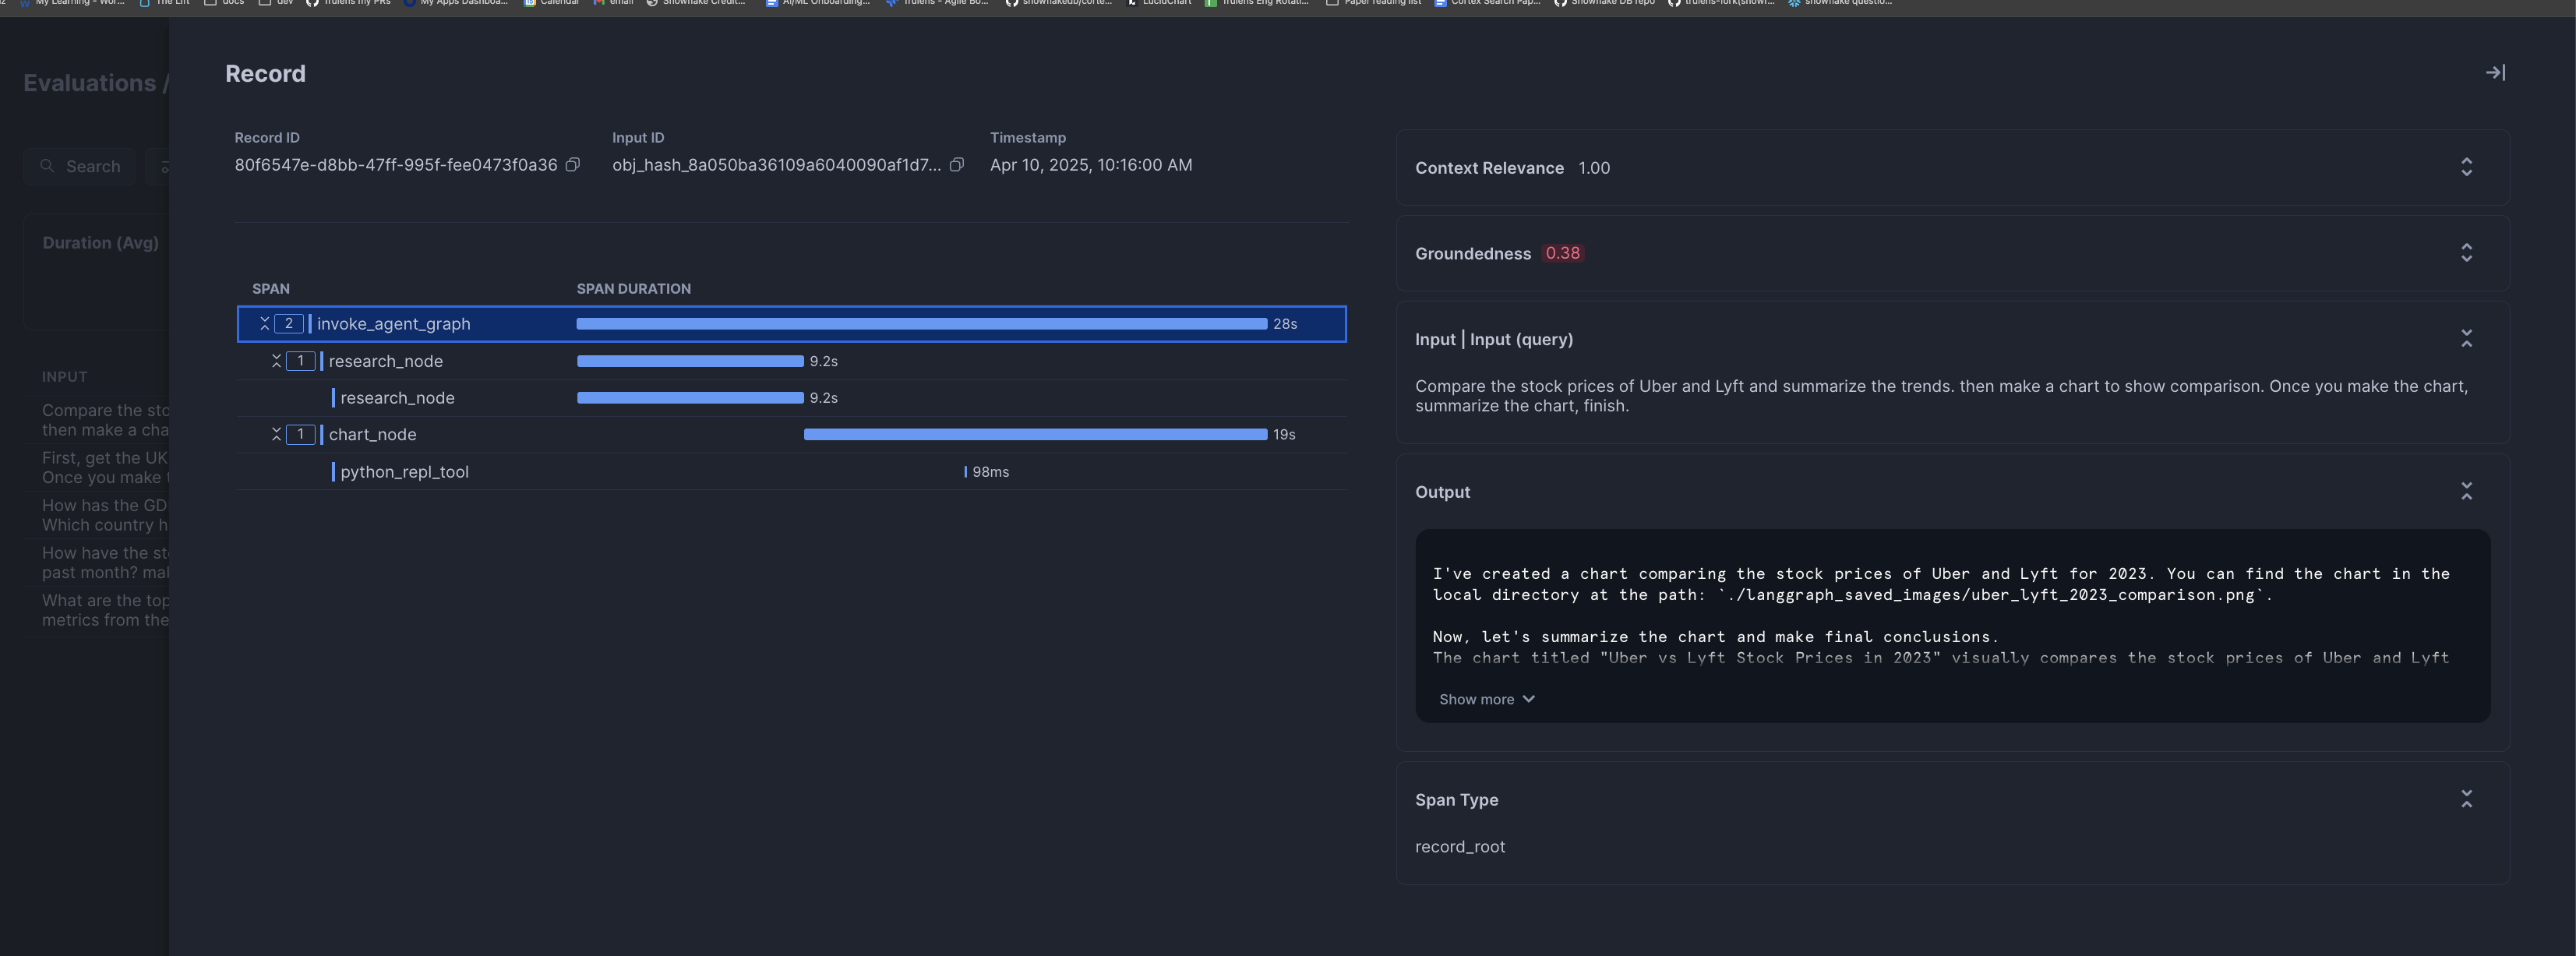

### The below cell is an example event from the agentic workflow

In [ ]:
event = {
    "researcher": {
        "messages": [
            HumanMessage(
                content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.",
                additional_kwargs={},
                response_metadata={},
                id="3ff2199c-0703-45f0-ba99-e286bf79b4f3",
            ),
            AIMessage(
                content="",
                additional_kwargs={
                    "tool_calls": [
                        {
                            "id": "call_sTvPH4qsp40CKy5y6SSDBzrz",
                            "function": {
                                "arguments": '{"query":"UK GDP for the past 5 years"}',
                                "name": "tavily_search_results_json",
                            },
                            "type": "function",
                        }
                    ],
                    "refusal": None,
                },
                response_metadata={
                    "token_usage": {
                        "completion_tokens": 26,
                        "prompt_tokens": 208,
                        "total_tokens": 234,
                        "completion_tokens_details": {
                            "accepted_prediction_tokens": 0,
                            "audio_tokens": 0,
                            "reasoning_tokens": 0,
                            "rejected_prediction_tokens": 0,
                        },
                        "prompt_tokens_details": {
                            "audio_tokens": 0,
                            "cached_tokens": 0,
                        },
                    },
                    "model_name": "gpt-4o-2024-08-06",
                    "system_fingerprint": "fp_6dd05565ef",
                    "id": "chatcmpl-BKCLTg40rHoaVCJGFbIwqhsVDGOb2",
                    "finish_reason": "tool_calls",
                    "logprobs": None,
                },
                id="run-1d4bdeb5-d00a-43d2-8b17-500975b1fcb3-0",
                tool_calls=[
                    {
                        "name": "tavily_search_results_json",
                        "args": {"query": "UK GDP for the past 5 years"},
                        "id": "call_sTvPH4qsp40CKy5y6SSDBzrz",
                        "type": "tool_call",
                    }
                ],
                usage_metadata={
                    "input_tokens": 208,
                    "output_tokens": 26,
                    "total_tokens": 234,
                    "input_token_details": {"audio": 0, "cache_read": 0},
                    "output_token_details": {"audio": 0, "reasoning": 0},
                },
            ),
            ToolMessage(
                content='[{"title": "UK GDP 2024 - Statista", "url": "https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/", "content": "GDP of the UK 1948-2023\\nPublished by D. Clark, Jan 6, 2025\\nThe gross domestic product of the United Kingdom in 2023 was just under 2.54 trillion British pounds, a slight increase when compared to the previous year. The significant drop in GDP between 2019 and 2020 was brought about by the COVID-19 pandemic and subsequent lockdowns, which caused severe damage to many industries, particularly in the service sector upon which the UK economy is heavily reliant. [...] Office for National Statistics (UK), Gross domestic product of the United Kingdom from 1948 to 2023 (in million GBP) Statista, https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/ (last visited February 08, 2025)\\nGross domestic product of the United Kingdom from 1948 to 2023 (in million GBP) [Graph], Office for National Statistics (UK), December 23, 2024. [Online]. Available: https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/ [...] Office for National Statistics (UK). (2024). Gross domestic product of the United Kingdom from 1948 to 2023 (in million GBP). Statista. Statista Inc.. Accessed: February 08, 2025. https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/\\nOffice for National Statistics (UK). \\"Gross Domestic Product of The United Kingdom from 1948 to 2023 (in Million Gbp).\\" Statista, Statista Inc., 23 Dec 2024, https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/", "score": 0.8380581}, {"title": "United Kingdom GDP Annual Growth Rate - Trading Economics", "url": "https://tradingeconomics.com/united-kingdom/gdp-growth-annual", "content": "The Gross Domestic Product (GDP) in the United Kingdom expanded 0.90 percent in the third quarter of 2024 over the same quarter of the previous year. GDP Annual Growth Rate in the United Kingdom averaged 2.33 percent from 1956 until 2024, reaching an all time high of 25.70 percent in the second quarter of 2021 and a record low of -21.90 percent in the second quarter of 2020. This page provides the latest reported value for - United Kingdom GDP Annual Growth Rate - plus previous releases, [...] The British economy expanded 0.9% year-on-year in Q3 2024, revised down from 1% in the preliminary estimate, but the highest growth since the first quarter of 2023. Government expenditure rose much less than initially anticipated (0.8% vs 1.8% in the preliminary estimate). In contrast, household spending (1.5% vs 1.2%) and gross fixed capital formation (3.9% vs 3.6%) of which business investment (5.8% vs 4.5%) grew at a faster pace. In addition, exports contracted less than in the preliminary [...] The British economy expanded 0.9% year-on-year in Q3 2024, revised down from 1% in the preliminary estimate, but the highest growth since the first quarter of 2023. Government expenditure rose much less than initially anticipated (0.8% vs 1.8% in the preliminary estimate). In contrast, household spending (1.5% vs 1.2%) and gross fixed capital formation (3.9% vs 3.6%) of which business investment (5.8% vs 4.5%) grew at a faster pace. In addition, exports contracted less than in the preliminary", "score": 0.7724109}, {"title": "U.K. GDP Growth Rate 1961-2025 | MacroTrends", "url": "https://www.macrotrends.net/global-metrics/countries/gbr/united-kingdom/gdp-growth-rate", "content": "U.K. gdp growth rate for 2023 was 0.10%, a 4.24% decline from 2022.\\nU.K. gdp growth rate for 2022 was 4.35%, a 4.33% decline from 2021.\\nU.K. gdp growth rate for 2021 was 8.67%, a 19.03% increase from 2020.\\nU.K. gdp growth rate for 2020 was -10.36%, a 12% decline from 2019. [...] | Ireland | -3.20% |\\n| U.K. GDP Growth Rate - Historical Data |\\n| --- |\\n| Year | GDP Growth (%) | Annual Change |\\n| --- | --- | --- |\\n| 2023 | 0.10% | -4.24% |\\n| 2022 | 4.35% | -4.33% |\\n| 2021 | 8.67% | 19.03% |\\n| 2020 | -10.36% | -12.00% |\\n| 2019 | 1.64% | 0.24% |\\n| 2018 | 1.40% | -1.25% |\\n| 2017 | 2.66% | 0.73% |\\n| 2016 | 1.92% | -0.30% |\\n| 2015 | 2.22% | -0.98% |\\n| 2014 | 3.20% | 1.40% |\\n| 2013 | 1.79% | 0.28% |\\n| 2012 | 1.51% | 0.37% |\\n| 2011 | 1.15% | -1.09% |\\n| 2010 | 2.24% | 6.85% |", "score": 0.76847315}, {"title": "United Kingdom GDP - Trading Economics", "url": "https://tradingeconomics.com/united-kingdom/gdp", "content": "The Gross Domestic Product (GDP) in the United Kingdom was worth 3340.03 billion US dollars in 2023, according to official data from the World Bank. The GDP value of the United Kingdom represents 3.17 percent of the world economy. source: World Bank [...] GDP in the United Kingdom averaged 1345.39 USD Billion from 1960 until 2023, reaching an all time high of 3340.03 USD Billion in 2023 and a record low of 73.23 USD Billion in 1960. This page provides the latest reported value for - United Kingdom GDP - plus previous releases, historical high and low, short-term forecast and long-term prediction, economic calendar, survey consensus and news. United Kingdom GDP - values, historical data and charts - was last updated on February of 2025. [...] GDP in the United Kingdom is expected to reach 3387.00 USD Billion by the end of 2025, according to Trading Economics global macro models and analysts expectations. In the long-term, the United Kingdom GDP is projected to trend around 3441.00 USD Billion in 2026 and 3496.00 USD Billion in 2027, according to our econometric models.\\n| Components | Last | Previous | Unit | Reference |\\n| --- | --- | --- | --- | --- |\\n| GDP from Agriculture | 4254.00 | 4215.00 | GBP Million | Sep 2024 |", "score": 0.7467494}, {"title": "Annual GDP growth in the UK 1949-2024 - Statista", "url": "https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/", "content": "Office for National Statistics (UK). (December 23, 2024). Annual growth of gross domestic product in the United Kingdom from 1949 to 2023 [Graph]. In Statista. Retrieved February 08, 2025, from https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/ [...] Office for National Statistics (UK). (2024). Annual growth of gross domestic product in the United Kingdom from 1949 to 2023. Statista. Statista Inc.. Accessed: February 08, 2025. https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/\\nOffice for National Statistics (UK). \\"Annual Growth of Gross Domestic Product in The United Kingdom from 1949 to 2023.\\" Statista, Statista Inc., 23 Dec 2024, https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/ [...] Office for National Statistics (UK), Annual growth of gross domestic product in the United Kingdom from 1949 to 2023 Statista, https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/ (last visited February 08, 2025)\\nAnnual growth of gross domestic product in the United Kingdom from 1949 to 2023 [Graph], Office for National Statistics (UK), December 23, 2024. [Online]. Available: https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/", "score": 0.73981786}]',
                name="tavily_search_results_json",
                id="def8fb4a-568b-46b2-9956-f1e8a42130f4",
                tool_call_id="call_sTvPH4qsp40CKy5y6SSDBzrz",
                artifact={
                    "query": "UK GDP for the past 5 years",
                    "follow_up_questions": None,
                    "answer": None,
                    "images": [],
                    "results": [
                        {
                            "url": "https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/",
                            "title": "UK GDP 2024 - Statista",
                            "content": 'GDP of the UK 1948-2023\nPublished by D. Clark, Jan 6, 2025\nThe gross domestic product of the United Kingdom in 2023 was just under 2.54 trillion British pounds, a slight increase when compared to the previous year. The significant drop in GDP between 2019 and 2020 was brought about by the COVID-19 pandemic and subsequent lockdowns, which caused severe damage to many industries, particularly in the service sector upon which the UK economy is heavily reliant. [...] Office for National Statistics (UK), Gross domestic product of the United Kingdom from 1948 to 2023 (in million GBP) Statista, https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/ (last visited February 08, 2025)\nGross domestic product of the United Kingdom from 1948 to 2023 (in million GBP) [Graph], Office for National Statistics (UK), December 23, 2024. [Online]. Available: https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/ [...] Office for National Statistics (UK). (2024). Gross domestic product of the United Kingdom from 1948 to 2023 (in million GBP). Statista. Statista Inc.. Accessed: February 08, 2025. https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/\nOffice for National Statistics (UK). "Gross Domestic Product of The United Kingdom from 1948 to 2023 (in Million Gbp)." Statista, Statista Inc., 23 Dec 2024, https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/',
                            "score": 0.8380581,
                            "raw_content": None,
                        },
                        {
                            "url": "https://tradingeconomics.com/united-kingdom/gdp-growth-annual",
                            "title": "United Kingdom GDP Annual Growth Rate - Trading Economics",
                            "content": "The Gross Domestic Product (GDP) in the United Kingdom expanded 0.90 percent in the third quarter of 2024 over the same quarter of the previous year. GDP Annual Growth Rate in the United Kingdom averaged 2.33 percent from 1956 until 2024, reaching an all time high of 25.70 percent in the second quarter of 2021 and a record low of -21.90 percent in the second quarter of 2020. This page provides the latest reported value for - United Kingdom GDP Annual Growth Rate - plus previous releases, [...] The British economy expanded 0.9% year-on-year in Q3 2024, revised down from 1% in the preliminary estimate, but the highest growth since the first quarter of 2023. Government expenditure rose much less than initially anticipated (0.8% vs 1.8% in the preliminary estimate). In contrast, household spending (1.5% vs 1.2%) and gross fixed capital formation (3.9% vs 3.6%) of which business investment (5.8% vs 4.5%) grew at a faster pace. In addition, exports contracted less than in the preliminary [...] The British economy expanded 0.9% year-on-year in Q3 2024, revised down from 1% in the preliminary estimate, but the highest growth since the first quarter of 2023. Government expenditure rose much less than initially anticipated (0.8% vs 1.8% in the preliminary estimate). In contrast, household spending (1.5% vs 1.2%) and gross fixed capital formation (3.9% vs 3.6%) of which business investment (5.8% vs 4.5%) grew at a faster pace. In addition, exports contracted less than in the preliminary",
                            "score": 0.7724109,
                            "raw_content": None,
                        },
                        {
                            "url": "https://www.macrotrends.net/global-metrics/countries/gbr/united-kingdom/gdp-growth-rate",
                            "title": "U.K. GDP Growth Rate 1961-2025 | MacroTrends",
                            "content": "U.K. gdp growth rate for 2023 was 0.10%, a 4.24% decline from 2022.\nU.K. gdp growth rate for 2022 was 4.35%, a 4.33% decline from 2021.\nU.K. gdp growth rate for 2021 was 8.67%, a 19.03% increase from 2020.\nU.K. gdp growth rate for 2020 was -10.36%, a 12% decline from 2019. [...] | Ireland | -3.20% |\n| U.K. GDP Growth Rate - Historical Data |\n| --- |\n| Year | GDP Growth (%) | Annual Change |\n| --- | --- | --- |\n| 2023 | 0.10% | -4.24% |\n| 2022 | 4.35% | -4.33% |\n| 2021 | 8.67% | 19.03% |\n| 2020 | -10.36% | -12.00% |\n| 2019 | 1.64% | 0.24% |\n| 2018 | 1.40% | -1.25% |\n| 2017 | 2.66% | 0.73% |\n| 2016 | 1.92% | -0.30% |\n| 2015 | 2.22% | -0.98% |\n| 2014 | 3.20% | 1.40% |\n| 2013 | 1.79% | 0.28% |\n| 2012 | 1.51% | 0.37% |\n| 2011 | 1.15% | -1.09% |\n| 2010 | 2.24% | 6.85% |",
                            "score": 0.76847315,
                            "raw_content": None,
                        },
                        {
                            "url": "https://tradingeconomics.com/united-kingdom/gdp",
                            "title": "United Kingdom GDP - Trading Economics",
                            "content": "The Gross Domestic Product (GDP) in the United Kingdom was worth 3340.03 billion US dollars in 2023, according to official data from the World Bank. The GDP value of the United Kingdom represents 3.17 percent of the world economy. source: World Bank [...] GDP in the United Kingdom averaged 1345.39 USD Billion from 1960 until 2023, reaching an all time high of 3340.03 USD Billion in 2023 and a record low of 73.23 USD Billion in 1960. This page provides the latest reported value for - United Kingdom GDP - plus previous releases, historical high and low, short-term forecast and long-term prediction, economic calendar, survey consensus and news. United Kingdom GDP - values, historical data and charts - was last updated on February of 2025. [...] GDP in the United Kingdom is expected to reach 3387.00 USD Billion by the end of 2025, according to Trading Economics global macro models and analysts expectations. In the long-term, the United Kingdom GDP is projected to trend around 3441.00 USD Billion in 2026 and 3496.00 USD Billion in 2027, according to our econometric models.\n| Components | Last | Previous | Unit | Reference |\n| --- | --- | --- | --- | --- |\n| GDP from Agriculture | 4254.00 | 4215.00 | GBP Million | Sep 2024 |",
                            "score": 0.7467494,
                            "raw_content": None,
                        },
                        {
                            "url": "https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/",
                            "title": "Annual GDP growth in the UK 1949-2024 - Statista",
                            "content": 'Office for National Statistics (UK). (December 23, 2024). Annual growth of gross domestic product in the United Kingdom from 1949 to 2023 [Graph]. In Statista. Retrieved February 08, 2025, from https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/ [...] Office for National Statistics (UK). (2024). Annual growth of gross domestic product in the United Kingdom from 1949 to 2023. Statista. Statista Inc.. Accessed: February 08, 2025. https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/\nOffice for National Statistics (UK). "Annual Growth of Gross Domestic Product in The United Kingdom from 1949 to 2023." Statista, Statista Inc., 23 Dec 2024, https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/ [...] Office for National Statistics (UK), Annual growth of gross domestic product in the United Kingdom from 1949 to 2023 Statista, https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/ (last visited February 08, 2025)\nAnnual growth of gross domestic product in the United Kingdom from 1949 to 2023 [Graph], Office for National Statistics (UK), December 23, 2024. [Online]. Available: https://www.statista.com/statistics/281734/gdp-growth-in-the-united-kingdom-uk/',
                            "score": 0.73981786,
                            "raw_content": None,
                        },
                    ],
                    "response_time": 1.09,
                },
            ),
            HumanMessage(
                content="The UK's GDP over the past five years (in trillion British pounds) according to Statista is as follows:\n\n- 2023: approximately 2.54 trillion GBP\n- 2022: Not explicitly stated, but could be inferred from the growth rate\n- 2021: Not explicitly stated, but could be inferred from the growth rate\n- 2020: There was a significant drop due to the COVID-19 pandemic\n- 2019: Higher than during the pandemic years, specific value not stated\n\nTo create a precise chart, we need the exact GDP figures for each of the past five years. Unfortunately, the exact values for each year from 2019 to 2022 aren't available in the search results directly. We can use the growth rates and changes in GDP to approximate these values if necessary. Would you like to proceed with an estimation based on the growth rate data, or should we attempt another round of searching for exact figures?",
                additional_kwargs={},
                response_metadata={},
                name="researcher",
                id="6d260247-b287-4d8f-a65d-f39192f6eff2",
            ),
        ]
    }
}